# Regression

## Imports

In [237]:
# data handling
import pandas as pd
import numpy as np
import time
# visualization
import matplotlib.pyplot as plt
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
# interpretation
from sklearn.inspection import PartialDependenceDisplay

## Prepare Data

In [238]:
trainDF = pd.read_csv('../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../app/data/02_test.csv', sep=';')

In [239]:
trainDF.head()

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,347.0
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,317.0
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,301.5
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,405.0
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,670.0


In [240]:
columns = trainDF.columns.to_list()
print(columns)

['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod', 'totalPrice']


In [241]:
X_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
X_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [242]:
X = X_train
y = y_train

In [243]:
X_train

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,communityAverage,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,39243.0,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,92516.0,133606,219943,3452460.0,470.8,2013,5,14,82499,136686
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,73113.0,133606,219943,3452460.0,470.8,2012,12,29,18058,136686
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,54612.0,81988,219943,3452460.0,470.8,2015,4,9,25725,136686
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,57510.0,81988,219943,3452460.0,470.8,2017,12,7,82499,136686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219938,116.451461,39.949365,57.49,2,1,1,1,6,118742,81641,...,72137.0,81988,219943,3452460.0,470.8,2012,12,15,48571,136686
219939,116.229624,39.915004,44.10,1,1,1,1,6,118742,81641,...,51471.0,81988,219943,3133469.0,426.0,2012,7,7,82499,16497
219940,116.310205,39.987486,138.14,3,2,1,2,16,58087,81641,...,79927.0,81988,219943,3133469.0,426.0,2011,12,5,44240,136686
219941,116.389264,39.886874,96.90,2,1,2,1,16,58087,81441,...,91507.0,4349,219943,1106214.0,46.5,2015,3,21,44240,136686


## ML

In [244]:
linearRegression = linear_model.LinearRegression()  # create linear regression
multipleLinearRegression = linearRegression.fit(X_train,y_train)
print('Coefficients: ', multipleLinearRegression.coef_)  # regression coefficients
print('intercept: ', multipleLinearRegression.intercept_)  # intercept

y_pred = multipleLinearRegression.predict(X_test)  # Make predictions using the testing set
print("\nMean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))  # The mean absolute error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))  # The mean squared error
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))  # The coefficient of determination: 1 is perfect prediction

Coefficients:  [-5.35120084e+01 -5.67574828e+00  4.13273385e+00 -3.11508740e+00
 -3.39441959e+00  8.52909395e+00 -7.58710365e+00 -6.96710294e-01
  7.83484842e-05  8.43983898e-04  2.18386796e-04  5.96270583e+01
  7.40139910e+00 -1.77410934e+01  5.75155937e+00  5.63486053e-02
  4.85243803e-03 -3.79882664e-05  3.90798505e-14  1.20393467e-05
 -4.72037277e-02  5.98392339e+01  3.94556938e+00  1.93077620e-01
  1.51549679e-04  4.92672353e-05]
intercept:  -114542.8440796356

Mean absolute error: 72.50
Mean squared error: 11685.29
Coefficient of determination (R^2): 0.78


In [245]:
# DF with predictions and deviation
predDF = X_test
predDF["totalPrice"] = y_test
predDF["prediction"] = y_pred
predDF["deviation"] = abs(predDF["totalPrice"] - predDF["prediction"])
predDF.head()

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice,prediction,deviation
0,116.432684,40.077562,104.02,2,1,1,1,6,118742,81441,...,2269487.0,1430.0,2015,11,21,82499,52625,237.5,303.543700,66.043700
1,116.432684,40.077562,102.27,2,1,1,1,20,58087,81641,...,2269487.0,1430.0,2013,7,27,82499,52625,210.0,169.041286,40.958714
2,116.438800,40.054941,53.00,2,1,1,2,17,41617,81441,...,3452460.0,470.8,2016,10,19,44240,52625,462.0,395.789440,66.210560
3,116.364866,39.964032,64.90,2,1,1,1,6,118742,81441,...,1106214.0,46.5,2016,7,5,82499,16497,390.0,406.785010,16.785010
4,116.364028,39.870465,69.10,2,2,1,1,6,118742,53150,...,1106214.0,46.5,2016,2,22,25725,136686,246.0,324.997748,78.997748


In [246]:
predDF["totalPrice"].describe()

count    94262.000000
mean       349.123993
std        228.231882
min          0.100000
25%        204.625000
50%        294.000000
75%        425.000000
max       5700.000000
Name: totalPrice, dtype: float64

In [247]:
predDF["prediction"].describe()

count    94262.000000
mean       349.332731
std        203.719091
min       -490.237879
25%        216.447146
50%        331.248282
75%        456.439663
max       2697.752297
Name: prediction, dtype: float64

In [248]:
predDF["deviation"].describe()

count    94262.000000
mean        72.497452
std         80.184014
min          0.000326
25%         26.350905
50%         54.591991
75%         93.472343
max       3385.397968
Name: deviation, dtype: float64

## Visualization & Interpretation

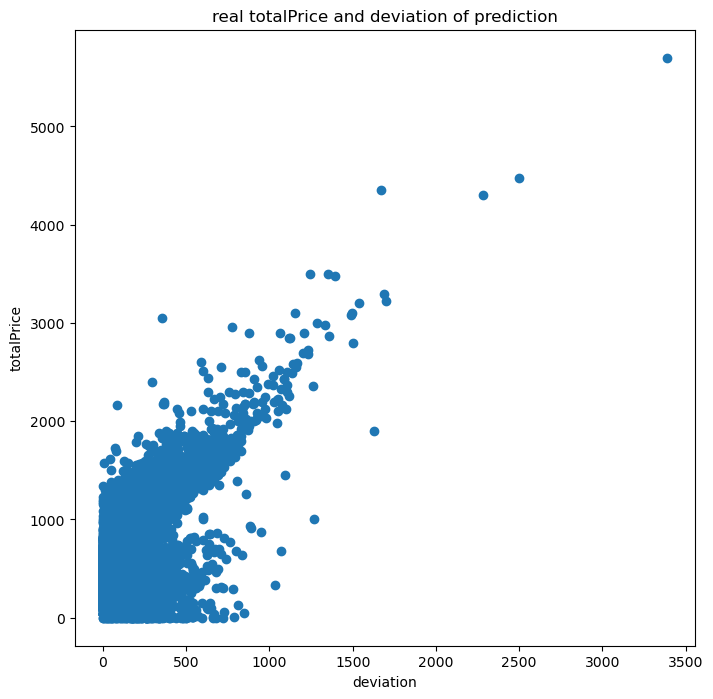

In [249]:
plt.figure(figsize=(8,8))
plt.scatter(predDF["deviation"], predDF["totalPrice"])
plt.title("real totalPrice and deviation of prediction")
plt.xlabel("deviation")
plt.ylabel("totalPrice")
plt.show()

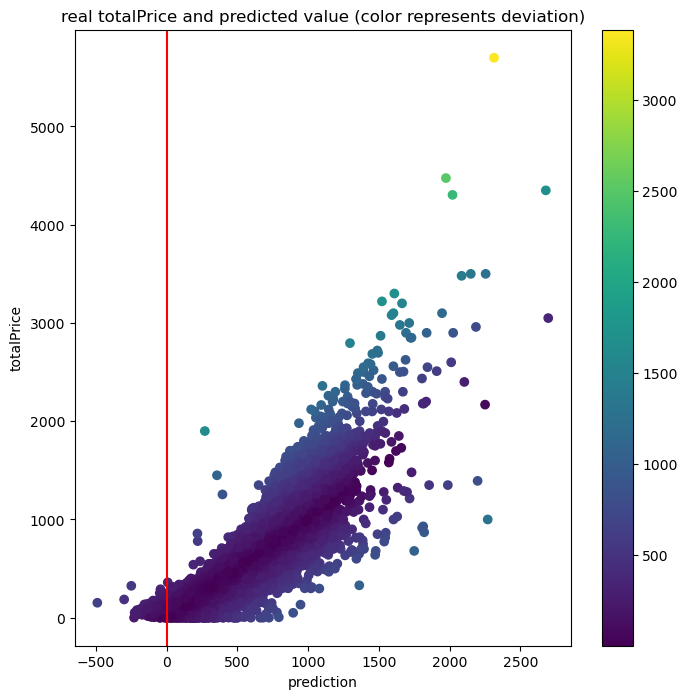

In [250]:
plt.figure(figsize=(8,8))
plt.scatter(predDF["prediction"], predDF["totalPrice"], c=predDF["deviation"])
plt.axvline(x=0, color="red")
plt.title("real totalPrice and predicted value (color represents deviation)")
plt.xlabel("prediction")
plt.ylabel("totalPrice")
plt.colorbar()
plt.show()

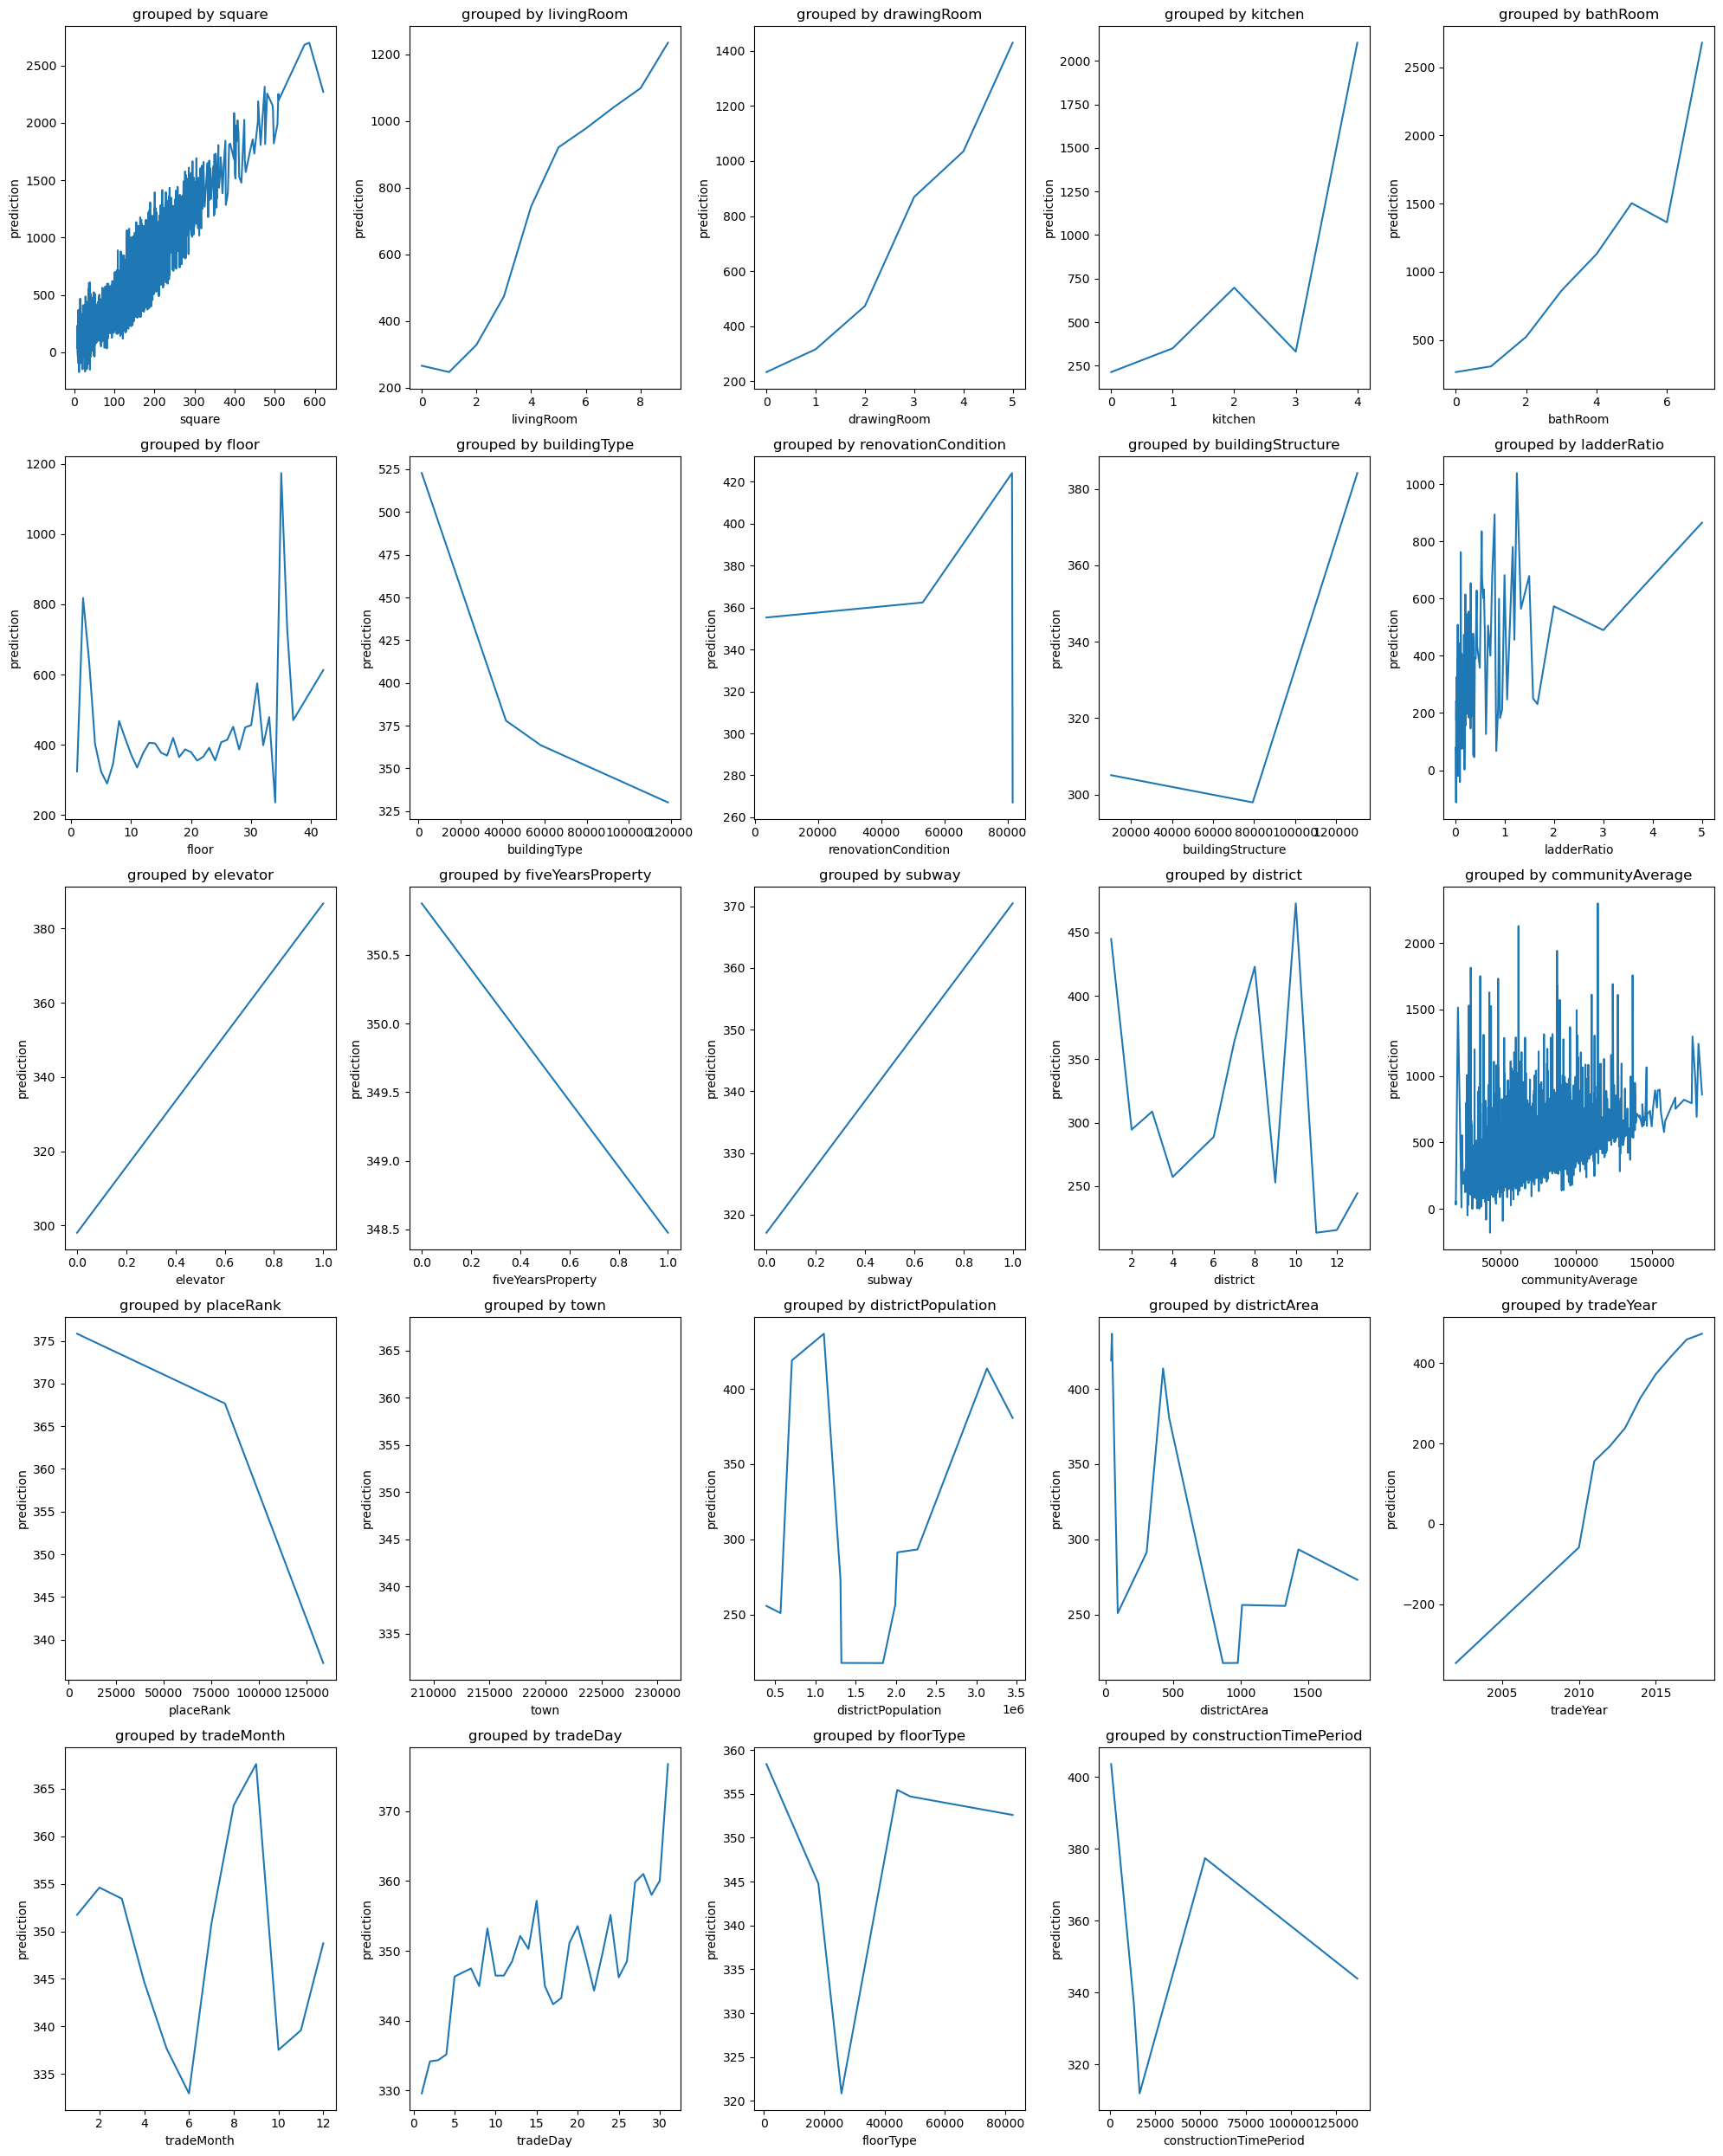

In [251]:
columns=['square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod']

plt.figure(figsize=(20,25))
i=0
for groupByFeature in columns:
    i+=1
    plt.subplot(5,5,i)
    plt.plot(predDF.groupby([groupByFeature]).mean()["prediction"])
    plt.title(f"grouped by {groupByFeature}")
    plt.xlabel(groupByFeature)
    plt.ylabel("prediction")
plt.tight_layout()
plt.show()

C:\Users\leand\AppData\Local\Temp\ipykernel_32724\2116187743.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


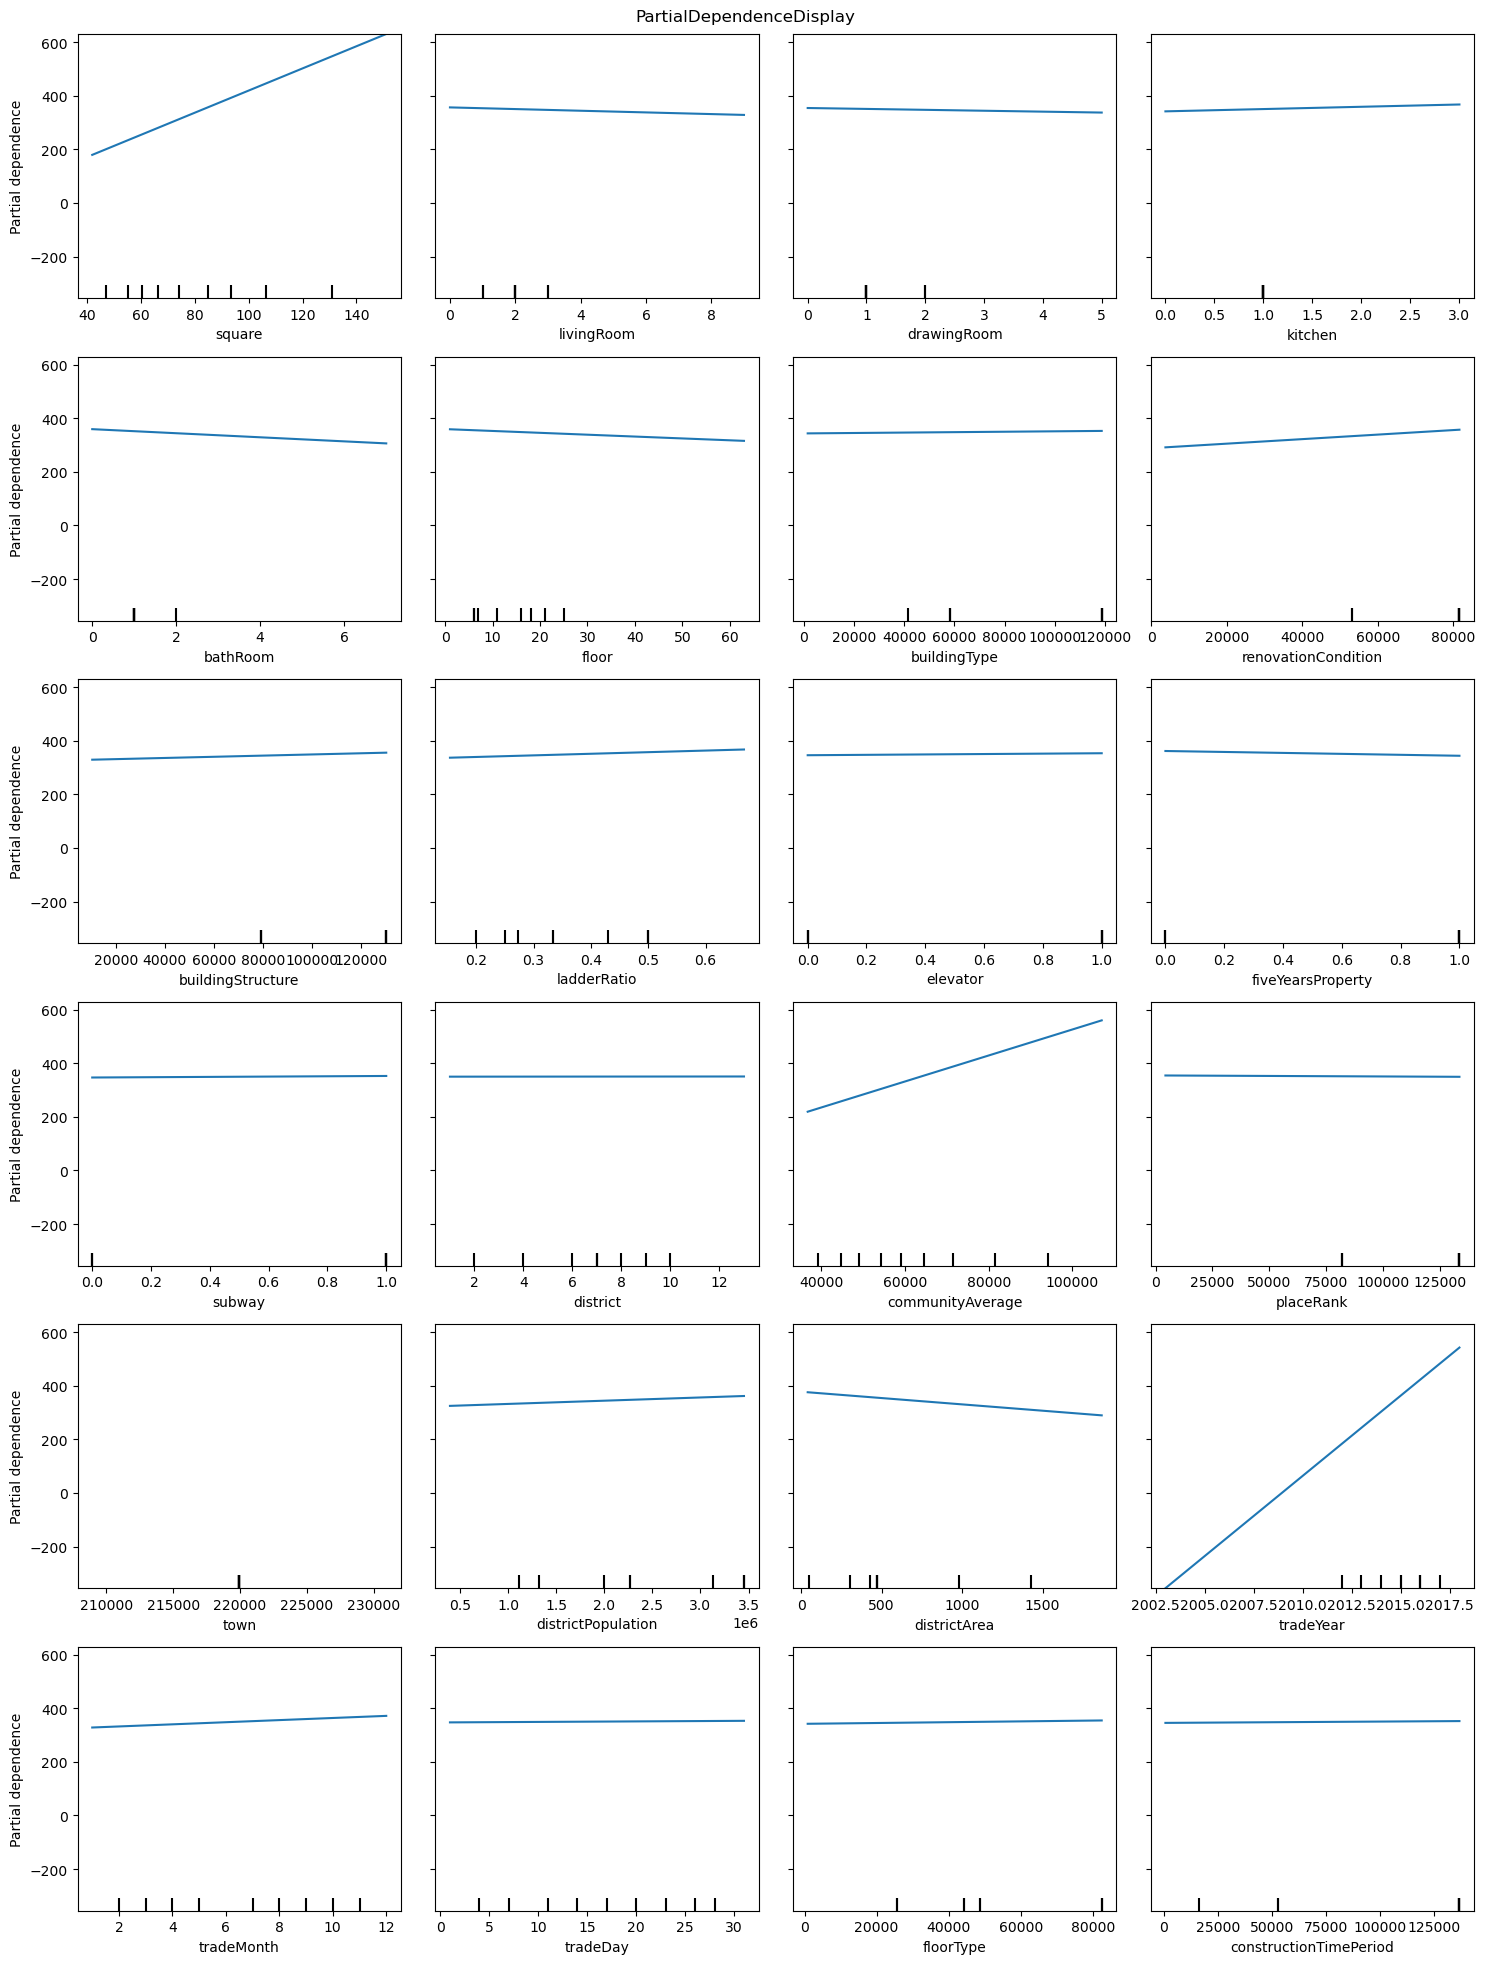

In [252]:
n_cols = 4
n_rows = 6
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,20))
PartialDependenceDisplay.from_estimator(multipleLinearRegression, X_train, columns, ax=ax, n_cols=n_cols)
fig.suptitle("PartialDependenceDisplay")
fig.tight_layout(rect=[0, 0, 1, 0.99])
fig.show()

## ML after Interpretation

> After looking into the interpretation plots we can see, that we can achieve almost the same accuracy with only a few features

In [253]:
columns_after_interpretation = ["square", "renovationCondition", "communityAverage", "tradeYear"]

In [254]:
linearRegression = linear_model.LinearRegression()  # create linear regression
multipleLinearRegression = linearRegression.fit(X_train[columns_after_interpretation],y_train)
print('Coefficients: ', multipleLinearRegression.coef_)  # regression coefficients
print('intercept: ', multipleLinearRegression.intercept_)  # intercept

y_pred = multipleLinearRegression.predict(X_test[columns_after_interpretation])  # Make predictions using the testing set
print("\nMean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))  # The mean absolute error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))  # The mean squared error
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))  # The coefficient of determination: 1 is perfect prediction

Coefficients:  [4.04703294e+00 8.43642909e-04 5.41201935e-03 5.83854446e+01]
intercept:  -118028.44717894148

Mean absolute error: 74.37
Mean squared error: 12400.17
Coefficient of determination (R^2): 0.76
